CSE575 Project - LSTM for predicting missing data

In [6]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.cluster import KMeans
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam


In [7]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
             

/kaggle/input/sensor-dataset/labapp3-data-new.txt


In [8]:
column_names = ["time", "nodeid", "temperature", "humidity", "light", "voltage"]
df = pd.read_csv("/kaggle/input/sensor-dataset/labapp3-data-new.txt", sep=" ", names=column_names, header=None)

np.random.seed(42)
df = df[df['nodeid'] <= 60]
df = df.sample(frac = 0.8)
df['time'] = pd.to_datetime(df['time'], unit='s')

In [15]:
df.isnull().sum()

time           0
nodeid         0
temperature    0
humidity       0
light          0
voltage        0
False          0
dtype: int64

In [16]:
df['temperature'=='inf']=
df['humidity'==] = 'Nan'
df['light'] = 'Nan'

In [17]:
# Preprocessing: Fill missing values
df['temperature'] = df['temperature'].interpolate(method='linear')
df['humidity'] = df['humidity'].interpolate(method='linear')
df['light'] = df['light'].interpolate(method='linear')
df = df.drop_duplicates()

/tmp/ipykernel_33/338685837.py:3: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df['humidity'] = df['humidity'].interpolate(method='linear')
/tmp/ipykernel_33/338685837.py:4: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df['light'] = df['light'].interpolate(method='linear')


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

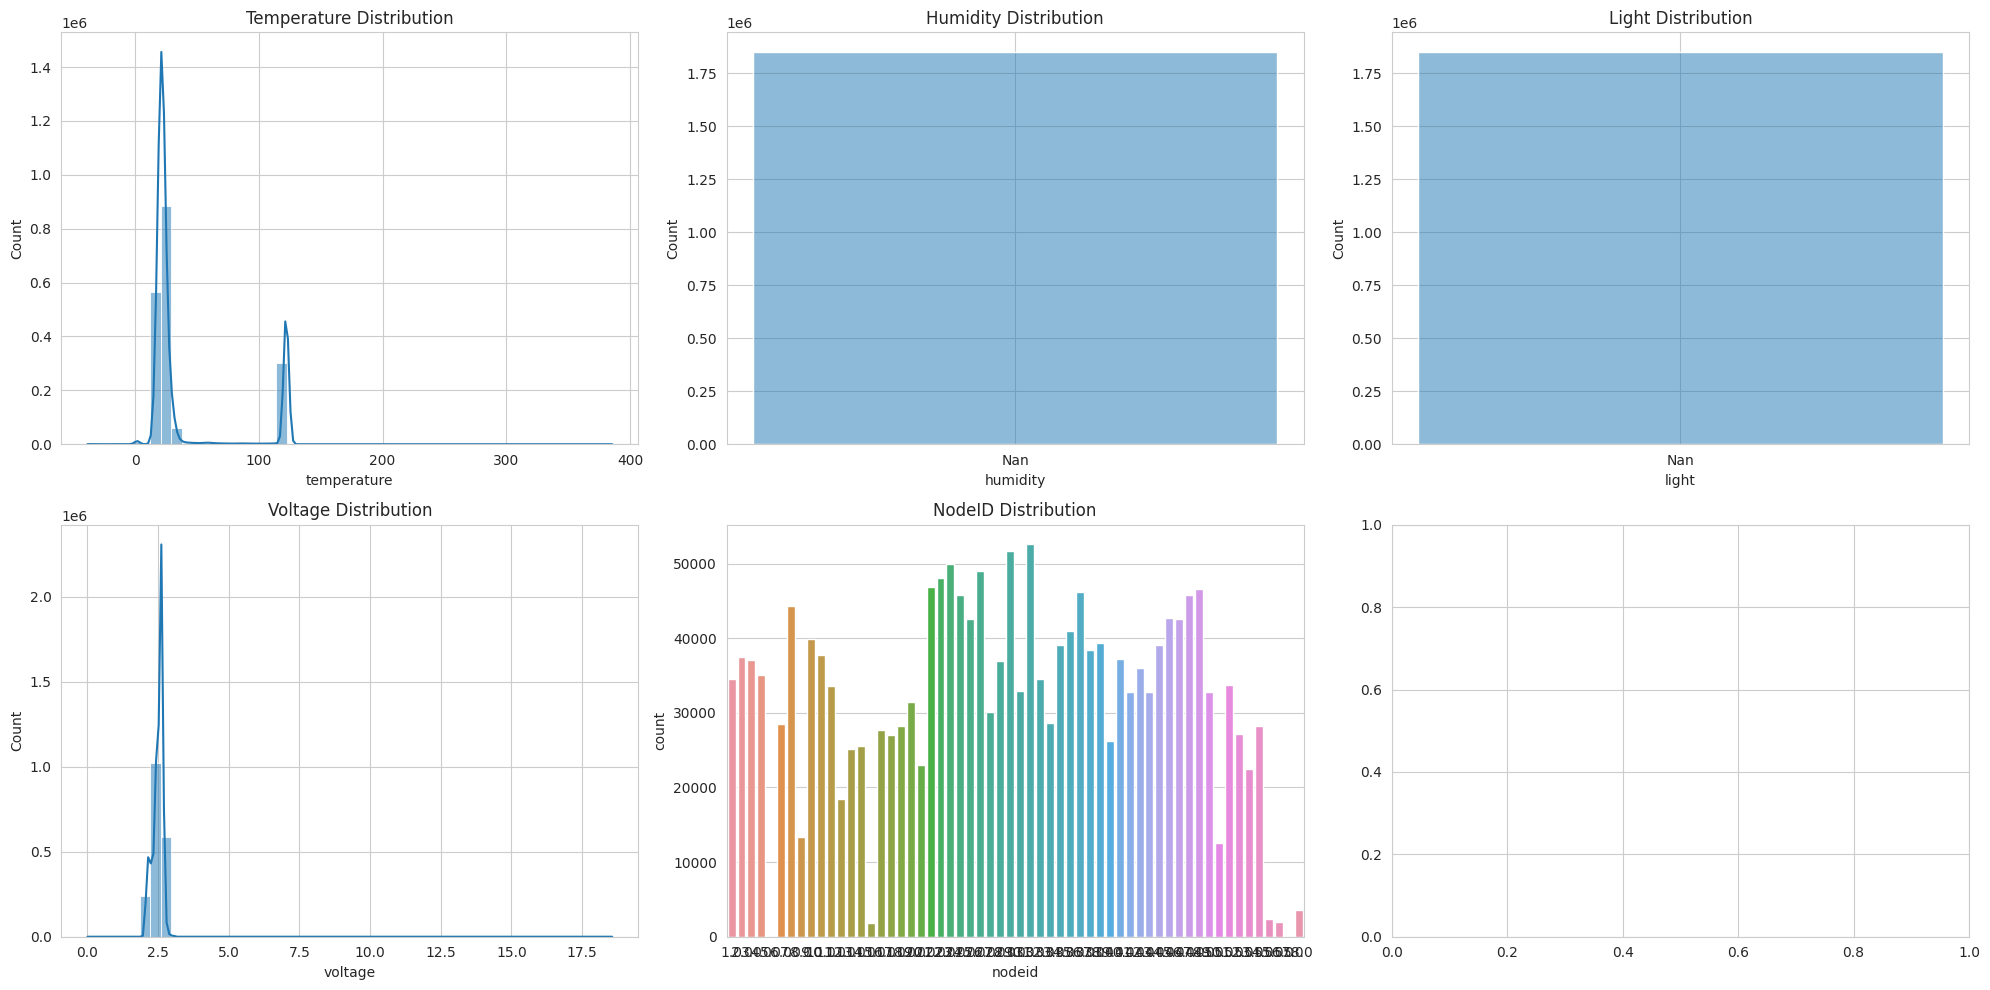

In [18]:
#data Visualization
sns.set_style("whitegrid")

# Plot data distribution for each feature
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

sns.histplot(df['temperature'], ax=axes[0, 0], bins=50, kde=True).set_title('Temperature Distribution')
sns.histplot(df['humidity'], ax=axes[0, 1], bins=50, kde=True).set_title('Humidity Distribution')
sns.histplot(df['light'], ax=axes[0, 2], bins=50, kde=True).set_title('Light Distribution')
sns.histplot(df['voltage'], ax=axes[1, 0], bins=50, kde=True).set_title('Voltage Distribution')
sns.countplot(data=df, x='nodeid', ax=axes[1, 1]).set_title('NodeID Distribution')

plt.tight_layout()
plt.show()

In [20]:
#Outliers
def handle_outliers(column):
    """Handles outliers in the column using the IQR method."""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Replace outliers with NaN for later interpolation
    outliers_count = df[column].apply(lambda x: 1 if x is not None and (x < lower_bound or x > upper_bound) else 0).sum()
    df[column] = df[column].apply(lambda x: x if lower_bound <= x <= upper_bound else None)
    
    return outliers_count

# Dictionary to store the count of outliers for each column
outliers_counts = {}

# Handle outliers for relevant columns and store the count
for col in ['temperature', 'humidity', 'light', 'voltage']:
    outliers_counts[col] = handle_outliers(col)

# Check the new number of null values after handling outliers
new_null_counts = df.isnull().sum()

# Print the count of outliers for each column
for col, count in outliers_counts.items():
    print(f'Number of outliers in {col}: {count}')

TypeError: unsupported operand type(s) for -: 'str' and 'str'

Part 2: Making array of arrays for LSTM with a window_size using Numpy

In [ ]:
# Making features dataframe by removing the label column
# features_df = cleanInput.drop("Temprature", axis=1)
# features_df = features_df.drop("Node_ID", axis=1)
features_df = result_df.drop("Node_ID", axis=1)
features_df = features_df.drop("Time", axis=1)
features_df = features_df.drop("Voltage", axis=1)
features_df = features_df.drop("Light", axis=1)
features_df = features_df.drop("Humidity", axis=1)

# Here define the sequence size - CHANGE IT WHEN FINE TUNNING
window_size = 48
predict_window_size = 12

# Transform dataframe to numpy
numpy_features_df = features_df.to_numpy()
numpy_df = result_df.to_numpy()

# Define X as array of features
# Define Y as array of actual output (label)
X=[]
Y=[]
Y_plot=[]
for i in range(len(numpy_df) - (window_size + predict_window_size)):
  # Use all features except for Tempreture -------------------------------------
  row = [r for r in numpy_features_df[i:i+window_size]]
  label=[]
  # Use this line if you want to predict one value
  label_plot = numpy_df[i+window_size][2]
  # Use this line only if you want to predict a sequece of values
  # label = [r1 for r1 in numpy_df[(i+window_size):(i+window_size+predict_window_size)][r1][2]]
  for x in range(predict_window_size):
    for r1 in [numpy_df[(i+window_size):(i+window_size+predict_window_size)][x]]:
      label.append(r1[2])
  X.append(row)
  Y.append(label)
  Y_plot.append(label_plot)



# converting into numpy
X1 = np.array(X)
Y1 = np.array(np.array(Y))

In [ ]:
# window_size = 20
# predict_window_size = 10
# i=2
# numpy_df[(i+window_size):(i+window_size+predict_window_size)]
# Y1 = np.reshape(Y1,(Y1.shape[0],Y1.shape[1],1))
# # numpy_df.shape

In [ ]:
# Checking for shape (#examples, window_size, features)
X1.shape, Y1.shape

((1649, 48, 1), (1649, 12))

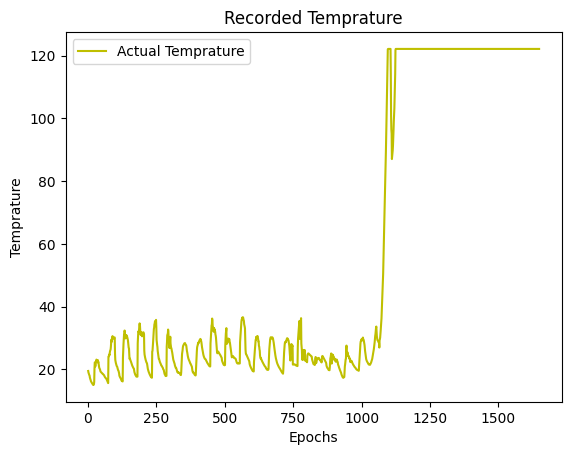

In [ ]:
# Plotting Prediction vs. actual values for training dataset
epochs = range(1, len(Y1)+1)
plt.plot(epochs, Y_plot, "y",label="Actual Temprature")
# plt.plot(epochs, train_predictions, "r", label="Predicted Temp")
plt.title("Recorded Temprature")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Temprature")
plt.show()

In [ ]:
# Just checking
X1, Y1

(array([[[ 19.7728],
         [ 18.6654],
         [ 18.4596],
         ...,
         [ 20.3118],
         [ 20.1256],
         [ 19.9492]],
 
        [[ 18.6654],
         [ 18.4596],
         [ 18.244 ],
         ...,
         [ 20.1256],
         [ 19.9492],
         [ 19.4396]],
 
        [[ 18.4596],
         [ 18.244 ],
         [ 18.0382],
         ...,
         [ 19.9492],
         [ 19.4396],
         [ 18.93  ]],
 
        ...,
 
        [[122.153 ],
         [122.153 ],
         [122.153 ],
         ...,
         [122.153 ],
         [122.153 ],
         [122.153 ]],
 
        [[122.153 ],
         [122.153 ],
         [122.153 ],
         ...,
         [122.153 ],
         [122.153 ],
         [122.153 ]],
 
        [[122.153 ],
         [122.153 ],
         [122.153 ],
         ...,
         [122.153 ],
         [122.153 ],
         [122.153 ]]]),
 array([[ 19.4396,  18.93  ,  18.6654, ...,  16.5388,  16.1664,  16.0292],
        [ 18.93  ,  18.6654,  18.4204, ...,  16.1664

Splitting the datasets into training, validation and testing

In [ ]:
import math

# Should ramdomize X1 and Y1 before splitting-----------------------------------

# print(len(Y1))
split1 = math.floor(len(Y1) * 0.1)
# print(split1)
split2 = math.floor(len(Y1) * 0.2)
# print(split2)

X_test = X1[:split1]
X_val = X1[split1:split2]
X_train = X1[split2:]

Y_test = Y1[:split1]
Y_val = Y1[split1:split2]
Y_train = Y1[split2:]

Y_plot_test = Y_plot[:split1]
Y_plot_val = Y_plot[split1:split2]
Y_plot_train = Y_plot[split2:]

# X_train.shape, Y_train.shape
# X_val.shape, Y_val.shape
# X_test.shape, Y_test.shape

Should use scaller on the above datasets??????????!!!!!!!!!!!!!!!

Part 3: NN Model

In [ ]:
model = Sequential()
model.add(InputLayer((window_size, 1)))
# model.add(Dropout(0.25))
model.add(LSTM(128))
# model.add(Dropout(0.2))
model.add(Dense(8, "relu"))
# model.add(Dropout(0.1))
model.add(Dense(1, "linear"))
model.summary()

Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 lstm (LSTM)                 (None, 128)               66560     

                                                                 

 dense (Dense)               (None, 8)                 1032      

                                                                 

 dense_1 (Dense)             (None, 1)                 9         

                                                                 


Total params: 67601 (264.07 KB)

Trainable params: 67601 (264.07 KB)

Non-trainable params: 0 (0.00 Byte)

_________________________________________________________________


Building and Training LSTM model

In [ ]:
checkPoint = ModelCheckpoint("model/", save_best_only = True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
hostory = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), verbose=1, epochs=100, callbacks=[checkPoint])

Epoch 1/100

42/42 [==============================] - 11s 213ms/step - loss: 6800.5986 - root_mean_squared_error: 82.4657 - val_loss: 568.6302 - val_root_mean_squared_error: 23.8460

Epoch 2/100

42/42 [==============================] - 6s 140ms/step - loss: 6641.5396 - root_mean_squared_error: 81.4956 - val_loss: 465.2907 - val_root_mean_squared_error: 21.5706

Epoch 3/100

42/42 [==============================] - 8s 200ms/step - loss: 6447.3389 - root_mean_squared_error: 80.2953 - val_loss: 364.7926 - val_root_mean_squared_error: 19.0995

Epoch 4/100

42/42 [==============================] - 6s 138ms/step - loss: 6249.4180 - root_mean_squared_error: 79.0533 - val_loss: 254.1833 - val_root_mean_squared_error: 15.9431

Epoch 5/100

42/42 [==============================] - 7s 181ms/step - loss: 5955.5088 - root_mean_squared_error: 77.1719 - val_loss: 157.0276 - val_root_mean_squared_error: 12.5311

Epoch 6/100

42/42 [==============================] - 6s 154ms/step - loss: 5645.9351 - r

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("model/")

In [ ]:
# Testing LSTM model

train_predictions = model.predict(X_train).flatten()
val_predictions = model.predict(X_val).flatten()
test_predictions = model.predict(X_test).flatten()

42/42 [==============================] - 1s 21ms/step

6/6 [==============================] - 0s 20ms/step

6/6 [==============================] - 0s 21ms/step


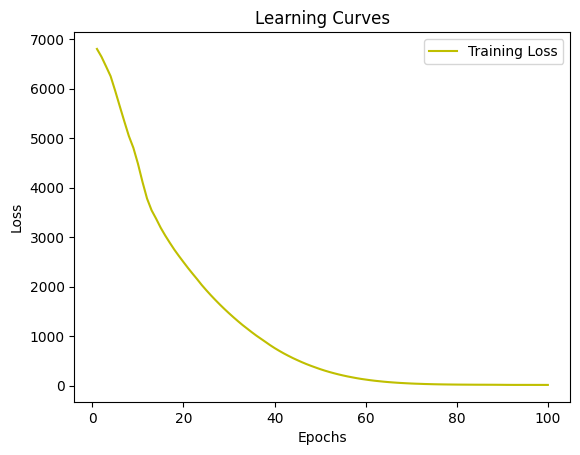

In [ ]:
# Plotting Learning curve
# Typo hostory :)

training_loss = hostory.history["loss"]
val_loss = hostory.history["val_loss"]
epochs = range(1, len(training_loss)+1)

plt.plot(epochs, training_loss, "y", label="Training Loss")
# plt.plot(epochs, val_loss, "r", label="Validation Loss")
plt.title("Learning Curves")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

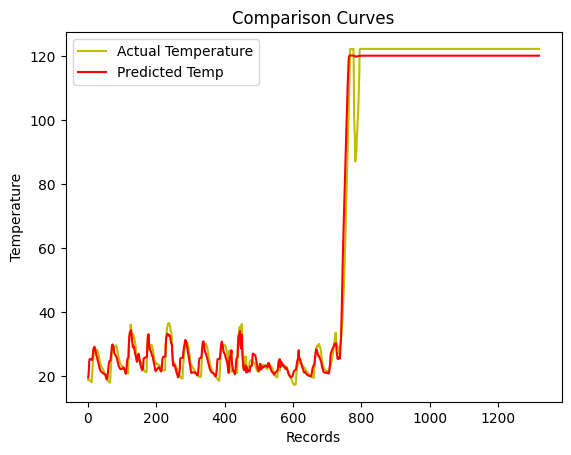

In [ ]:
# Plotting Prediction vs. actual values for training dataset
epochs = range(1, len(Y_plot_train)+1)
plt.plot(epochs, Y_plot_train, "y", label="Actual Temperature")
plt.plot(epochs, train_predictions, "r", label="Predicted Temp")
plt.title("Comparison Curves")
plt.legend()
plt.xlabel("Records")
plt.ylabel("Temperature")
plt.show()

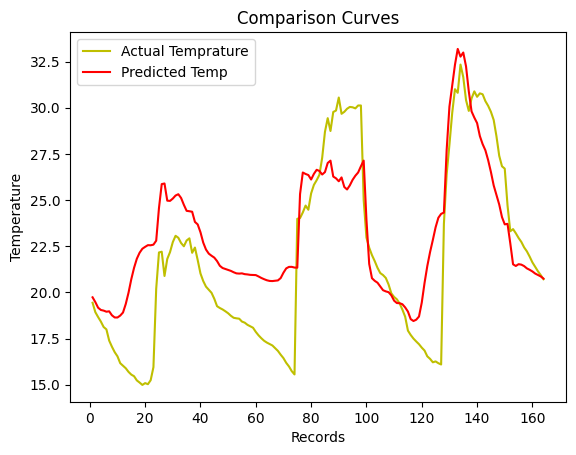

In [ ]:
# Plotting Prediction vs. actual values for test dataset
epochs = range(1, len(Y_plot_test)+1)
plt.plot(epochs, Y_plot_test, "y", label="Actual Temprature")
plt.plot(epochs, test_predictions, "r", label="Predicted Temp")
plt.title("Comparison Curves")
plt.legend()
plt.xlabel("Records")
plt.ylabel("Temperature")
plt.show()

In [ ]:
Y_test, test_predictions

(array([[19.4396, 18.93  , 18.6654, ..., 16.5388, 16.1664, 16.0292],
        [18.93  , 18.6654, 18.4204, ..., 16.1664, 16.0292, 15.892 ],
        [18.6654, 18.4204, 18.1264, ..., 16.0292, 15.892 , 15.696 ],
        ...,
        [21.1448, 20.939 , 20.7136, ..., 18.7928, 18.5184, 18.2636],
        [20.939 , 20.7136, 20.5274, ..., 18.5184, 18.2636, 18.1166],
        [20.7136, 20.5274, 20.4   , ..., 18.2636, 18.1166, 17.9402]]),
 array([19.734295, 19.47524 , 19.172375, 19.04933 , 19.014072, 18.955137,
        18.975817, 18.760271, 18.642818, 18.641033, 18.74612 , 18.910934,
        19.375753, 19.986395, 20.717081, 21.332022, 21.823454, 22.148075,
        22.36488 , 22.466955, 22.558008, 22.551851, 22.585913, 22.801105,
        24.565779, 25.864458, 25.89765 , 24.96815 , 24.955164, 25.080603,
        25.24594 , 25.31657 , 25.113342, 24.74256 , 24.417196, 24.395456,
        24.367445, 23.81732 , 23.681202, 23.25882 , 22.698011, 22.321077,
        22.100183, 21.985403, 21.884077, 21.696123, 2

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Calculate Mean Squared Error (MSE) and Mean Absolute Error (MAE)
mse = mean_squared_error(Y_plot_test, test_predictions)
mae = mean_absolute_error(Y_plot_test, test_predictions)


In [ ]:
mse, mae

(9.839422902148558, 2.54010891148637)

In [ ]:
Y_test.shape,test_predictions.shape

((164, 12), (164,))

In [ ]:
test_predictions

array([19.734295, 19.47524 , 19.172375, 19.04933 , 19.014072, 18.955137,
       18.975817, 18.760271, 18.642818, 18.641033, 18.74612 , 18.910934,
       19.375753, 19.986395, 20.717081, 21.332022, 21.823454, 22.148075,
       22.36488 , 22.466955, 22.558008, 22.551851, 22.585913, 22.801105,
       24.565779, 25.864458, 25.89765 , 24.96815 , 24.955164, 25.080603,
       25.24594 , 25.31657 , 25.113342, 24.74256 , 24.417196, 24.395456,
       24.367445, 23.81732 , 23.681202, 23.25882 , 22.698011, 22.321077,
       22.100183, 21.985403, 21.884077, 21.696123, 21.441208, 21.321142,
       21.268854, 21.221804, 21.164927, 21.091381, 21.03111 , 21.018848,
       21.030502, 20.988361, 20.973452, 20.949968, 20.94107 , 20.937365,
       20.864052, 20.783232, 20.715853, 20.657404, 20.621157, 20.61407 ,
       20.630732, 20.649525, 20.776003, 21.066841, 21.300531, 21.381348,
       21.38358 , 21.345419, 21.338953, 25.32339 , 26.491821, 26.413502,
       26.354807, 26.11289 , 26.415382, 26.63862 , 

In [ ]:
Y_test

array([[19.4396, 18.93  , 18.6654, ..., 16.5388, 16.1664, 16.0292],
       [18.93  , 18.6654, 18.4204, ..., 16.1664, 16.0292, 15.892 ],
       [18.6654, 18.4204, 18.1264, ..., 16.0292, 15.892 , 15.696 ],
       ...,
       [21.1448, 20.939 , 20.7136, ..., 18.7928, 18.5184, 18.2636],
       [20.939 , 20.7136, 20.5274, ..., 18.5184, 18.2636, 18.1166],
       [20.7136, 20.5274, 20.4   , ..., 18.2636, 18.1166, 17.9402]])